<a href="https://colab.research.google.com/github/PPierzc/PracowniaEEG/blob/master/Widmowa_analiza_parametryczna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

! rm -rf PracowniaEEG
! git clone https://github.com/PPierzc/PracowniaEEG.git
  
import PracowniaEEG.filters as filters
import PracowniaEEG.cw4_utils as utils
import PracowniaEEG.mtmvar as mtmvar

! pip install wget
import wget

!pip install obci_readmanager
from obci_readmanager.signal_processing.read_manager import ReadManager

import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import scipy


sns.set()
sns.set_context("talk", font_scale=1.4)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Cloning into 'PracowniaEEG'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 157 (delta 77), reused 73 (delta 23), pack-reused 0
Receiving objects: 100% (157/157), 23.56 MiB | 14.41 MiB/s, done.
Resolving deltas: 100% (77/77), done.
  Running setup.py bdist_wheel for wget ... - done
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4

# Zadanie 1

In [0]:
filename = "gdrive/My Drive/pracowniaEEG/cw1/otwarte"
mgr = ReadManager("%s.xml"%filename, "%s.raw"%filename, "%s.tag"%filename)
fs = int(float(mgr.get_param("sampling_frequency")))
num_of_channels = int(mgr.get_param("number_of_channels"))
channels_names = mgr.get_param("channels_names")

raw_syg_open = mgr.get_microvolt_samples()
t = np.arange(raw_syg_open.shape[1])/fs

choosen_channel = "O2"
s = raw_syg_open[channels_names.index(choosen_channel),:]
del(raw_syg_open)

s = filters.butter_highpass_filter(s, 1, fs, order=5)
# s = filters.notch_filter(s, 50, fs)

s = s[len(s)//2 : len(s)//2 + 1000]
s = s.reshape(1, s.size)

x = np.arange(s.size)
x = x.reshape(1, x.size)


2018-12-20 13:43:04,915 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


(1, 1000)


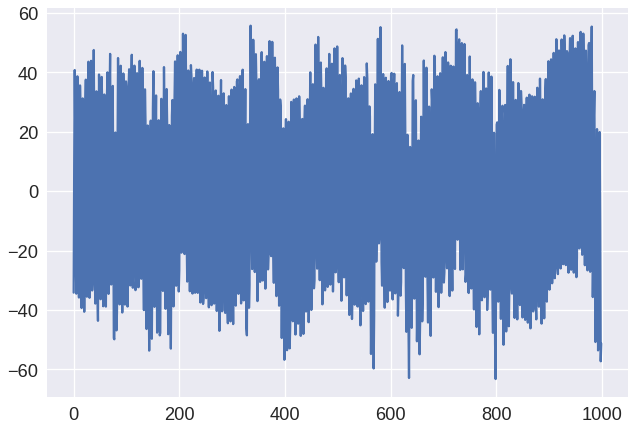

In [0]:
plt.figure()
plt.plot(x[0],s[0])
plt.show()
plt.close()

1 [[[0.3903067]]]
2 [[[ 0.75133459]]

 [[-0.92498511]]]
3 [[[ 1.59470344]]

 [[-1.61002553]]

 [[ 0.91176478]]]
4 [[[ 1.66577228]]

 [[-1.73552134]]

 [[ 1.03606628]]

 [[-0.07794647]]]
5 [[[ 1.6301757 ]]

 [[-1.26237076]]

 [[ 0.2434887 ]]

 [[ 0.68277813]]

 [[-0.45667983]]]


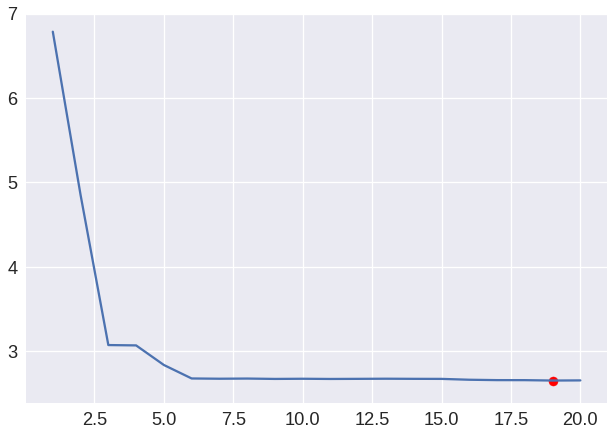

In [0]:
AIC = utils.coeffs(s, 1, 5)
for _x in AIC:
  print(len(_x[0]), _x[0])
  
AIC = utils.get_aic_func(s, 1, 20)
order, params, coefs = utils.best_akaike(s, 1, 20)

plt.figure()
plt.plot(list(range(1, 21)), AIC)
plt.scatter(order, np.log(np.linalg.det(coefs)) + 2 * order * s.shape[0] * s.shape[0] / s.shape[1], color='r')
plt.show()
plt.close()



#Zadanie 2

In [0]:
def widomo_f(s, order, f, Fs=128):
  k = np.shape(s)[0]
  
  coef, V = mtmvar.mult_AR(s, order, 1)
  A = np.eye(k, dtype='complex')
  
  for j in range(0, k):
    for i  in range(len(coef)):
      A +=coef[i,:,:]*(np.exp(2*1j*np.pi*f/Fs))**(-j-1)
      
  H = np.linalg.inv(A)
  widma = np.dot(np.dot(H,V), np.matrix(H).H)
  return A, H, widma

# def widomo_f(s, order, f, Fs=128):
#   k = np.shape(s)[0]
  
#   coef, V = mtmvar.mult_AR(s, order, 1)
#   A = np.eye(k, dtype='complex')
  
#   for j in range(k):
#     for i in range(1, len(coef)+1):
#       A -=coef[i,:,:]*(np.exp(2*1j*np.pi*f/Fs))**(-i-1)
      
#   H = np.linalg.inv(A)
#   widma = np.dot(np.dot(H,V), np.matrix(H).H)
#   return A, H, widma

def widomo(s, order, f_max, Fs=128):
  efs = np.arange(0, f_max+1, .1)
  widma = np.empty(efs.size, dtype="complex")
  for i, f in enumerate(efs):
    q = widomo_f(s, order, f, Fs)
    p = q[-1][0,0]
    widma[i] = p
    

  return efs, widma
  
  

In [0]:
range(0, 10) == range(10)

True

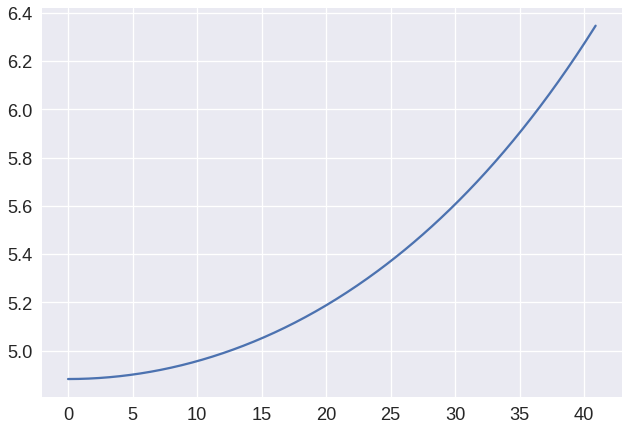

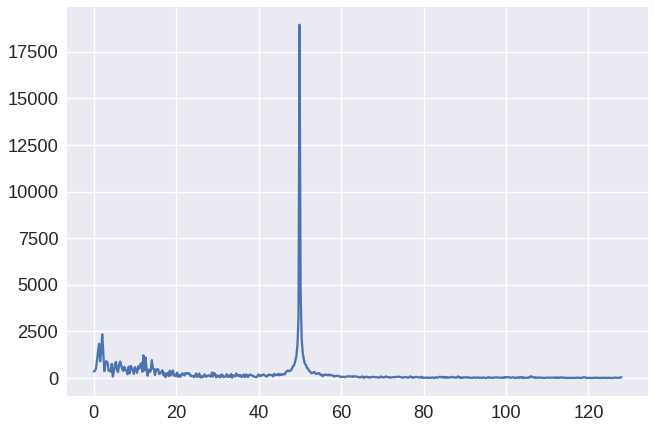

In [0]:
xf, S = widomo(s, order, 40, fs)
plt.figure()
plt.plot(xf, abs(S))
plt.show()
plt.close()


plt.figure()
S = np.fft.rfft(s)
freq = np.fft.rfftfreq(s.size, d=1./fs)
plt.plot(freq, abs(S[0,:]))
plt.show()
plt.close()

In [0]:
f

59

In [0]:
s

array([[-34.18073333,   9.14560748,  40.74800815,  19.65698051,
        -23.88296456, -34.53081718,   3.65793153,  38.63128946,
         25.77326348, -16.8266405 , -35.82941761,  -4.27956398,
         35.56642327,  26.50854598, -17.36769499, -39.3627998 ,
        -11.44876959,  31.19639344,  30.44318615, -12.56439563,
        -40.62635708, -17.34920435,  28.38105542,  37.50541411,
         -1.7736374 , -35.54510919, -17.0480123 ,  29.83664127,
         43.54733856,   3.63506567, -35.91769225, -23.48795095,
         22.69177287,  43.84846163,  10.23809684, -33.45184088,
        -28.94887179,  17.95548298,  47.48720147,  18.31926085,
        -29.29386251, -37.86619308,   3.97074387,  33.58292231,
         11.21631541, -34.02860442, -43.6648655 ,   0.96900313,
         39.24097169,  25.96300973, -19.4169139 , -36.40983098,
         -0.34827397,  38.43172405,  28.37862942, -17.70909214,
        -38.77047548,  -8.350556  ,  32.50963036,  31.04304717,
        -12.60734253, -38.88207616, -12.

In [0]:
|# Af, Hf

def Et(s, order):
  A, _ = mtmvar.mult_AR(s, order, 1)
  A = np.array([np.eye(A[0].shape[0])] + A.tolist())
  
  Et = []
  #for channel in range(s.shape[0])
  for t in range(s.shape[1]):
    tmp = 0
    for j in range(A.shape[0]):
      tmp += A[j]*s[:,t-j]
      
    Et.append(tmp)
  return np.array(Et)
      



def magic_function(s, order, f, fs):
  dt = 1/fs
  
  Xf = np.fft.fft(s)
  Xf = np.transpose(Xf, (1, 0))
  Et_ = Et(s, order)
  Ef = np.fft.fft(Et_)
  Hf = np.linalg.solve(Ef,Xf)

  A, _ = mtmvar.mult_AR(s, order, 1)
  Az = z_transform(A, f, fs)
  Ez = z_transform(Ef, f, fs)
  Af = np.log(Az*fs)/(2*np.pi *1j)
   
  
  return Af, Hf

In [0]:
a, b = magic_function(s, 10, 32, 128)

a

NameError: ignored

In [0]:
Et(s, 10).shape

In [0]:
def S(s):
  S = scipy.fftpack.fft(s)
  return abs(S)

In [0]:
|plt.plot(S(s))

In [0]:
def X(s, Fs, axis=0):
  N = s.shape[1]
  # sample spacing
  T = 1.0 / Fs
  yf = scipy.fftpack.fft(s)
  xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
  return N, xf, yf



def S(s,f):
  _, Xfs = X(s)
  Xf = Xfs[f]
  return Xf *  Xf.conj

In [0]:
a,b = X(s, 128)

print(a.shape,b.shape)

In [0]:
fig, ax = plt.subplots()
N, xf, yf = X(s, 128)
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()

In [0]:
order, params, coefs = utils.best_akaike(s, 1, 20)
A, V = mtmvar.mult_AR(s, order, 1)

A_f = lambda f: utils.z_transform(A, f, fs)
H_f = lambda f: np.matrix(A_f(f)).I

print(A_f(20))
print(H_f(20))

In [0]:
A.shape

In [0]:
S_f = lambda f: np.dot(np.dot(H_f(f), V), np.matrix(H_f(f)).H)

plt.figure()
for f in np.arange(0, fs // 2):
  plt.stem([f], S_f(f)[0])

plt.show()
plt.close()

plt.figure()
S = np.fft.rfft(s)
print(S)
plt.plot(np.abs(S)**2)
plt.show()
plt.close()

#Zadanie 3

In [0]:
def sin(f=21,N=1000,Fs=128,phi=0):
	dt = 1.0/Fs
  
	x = np.arange(0,N/Fs,dt)
	g = np.sin(2*np.pi*f*x + phi)
	return x, g

x, g1 = sin()
x, g2 = sin(np.pi/4)
g2 += np.random.random(g2.size) * 0.2
s = np.array([g1,g2])

order, params, coefs = utils.best_akaike(s, 1, 20)
A, V = mtmvar.mult_AR(s, order, 1)

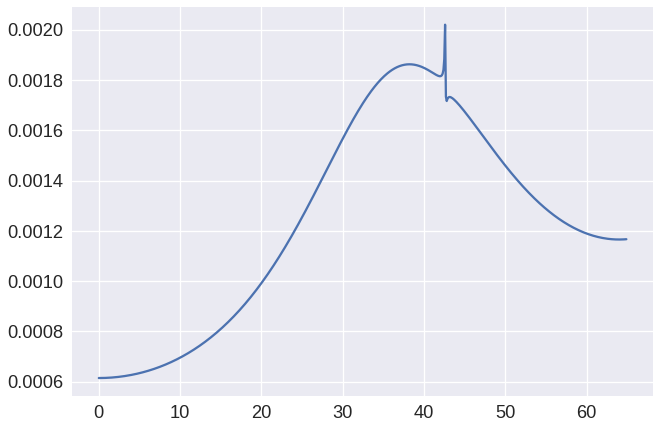

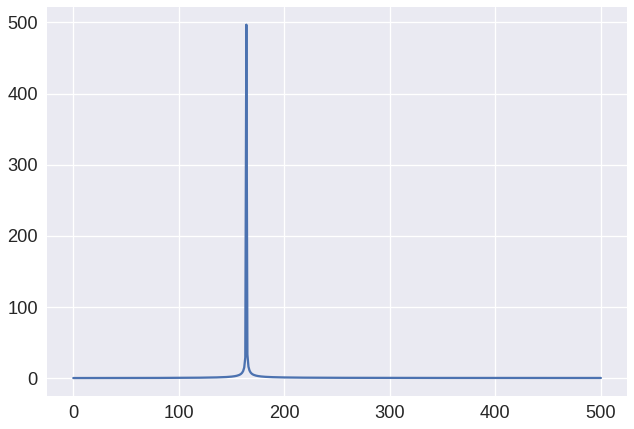

In [0]:

fs = 128
order=3
xf, S = widomo(s, order, fs//2, fs)
plt.figure()
plt.plot(xf, abs(S))

plt.show()
plt.close()


plt.figure()
S = np.fft.rfft(g1)
freq = np.fft.rfftfreq(s.size, d=1./fs)
plt.plot(abs(S))
plt.show()
plt.close()

In [0]:
"plt.plot(x,s[0])

In [0]:
A, V = mtmvar.mult_AR(s, order, 1)

In [0]:
order

In [0]:
A.shape

# Zadanie 4

# Zadanie 5


In [0]:
def z_transform(A, f, fs):
  z = np.exp(2 * np.pi * f / fs)

  F = sum([A[j] * z ** (-j) for j in range(len(A))])

  return F

def z_transform(A, f, fs):
  z = np.exp(2 * np.pi * f / fs)

  F = sum([np.eye(A[0].shape[0])] + [A[j] * z ** (-j - 1) for j in range(len(A))])
  return F


In [0]:
q = np.array([[1,2,], [2,1]])
z_transform(q,200,1)

In [0]:
?np.eye

In [0]:
A

In [0]:
def sin(f=32, N=1000, Fs=128, phi=0):
 
	dt = 1.0/Fs
	x = np.arange(0,N/Fs,dt)
	g = np.sin(2*np.pi*f*x + phi)
	return x, g

x, g1 = sin()

plt.plot(x, g1)

x, g2 = sin(phi=np.pi/4)
g2 += np.random.random(g2.size) * 0.2
s = np.array([g1,g2])

order, params, coefs = utils.best_akaike(s, 1, 20)
A, V = mtmvar.mult_AR(s, order, 1)

l = [z_transform(A, f, 128)[0][1] for f in range(1,64)]
# plt.plot(l)

In [0]:
|plt.plot(l)

In [0]:
?scipy.fft